# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [1]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [2]:
bandit0 = BanditProblem(0) 

In [3]:
bandit0.get_num_arms()

3

In [4]:
bandit0.get_reward(arm=0)

1.8255111545554434

In [5]:
# YOUR CHANGES HERE

num_samples = 10000
num_arms = bandit0.get_num_arms()
samples = {arm: [] for arm in range(num_arms)}
for arm in range(num_arms):
    for _ in range(num_samples):
        samples[arm].append(bandit0.get_reward(arm))
#convert to np array
for arm in samples:
    samples[arm] = np.array(samples[arm])
#print stats
for arm in range(num_arms):
    print(f"Arm {arm}:")
    print(f' min = {samples[arm].min():.4f}')
    print(f' mean = {samples[arm].mean():.4f}')
    print(f' max = {samples[arm].max():.4f}')
    print(f' std = {samples[arm].std():.4f}')

Arm 0:
 min = 0.0000
 mean = 0.8352
 max = 6.7825
 std = 0.8149
Arm 1:
 min = 0.0000
 mean = 0.6091
 max = 4.8481
 std = 0.6719
Arm 2:
 min = 0.0000
 mean = 0.9092
 max = 4.9967
 std = 0.8255


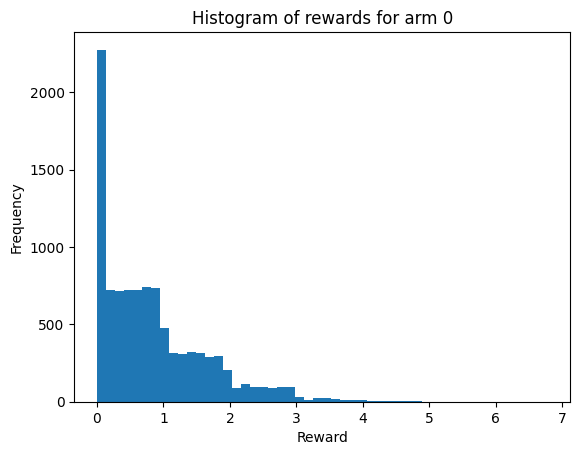

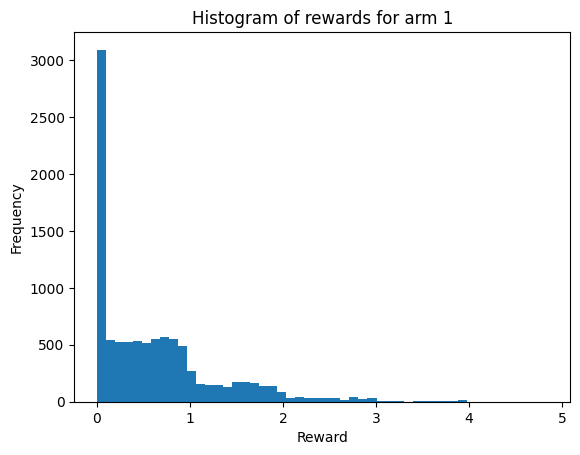

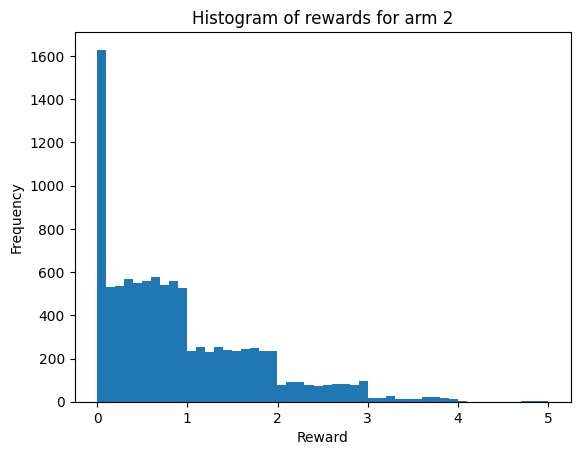

In [6]:
#create histograms
import matplotlib.pyplot as plt
for arm in range(num_arms):
    plt.hist(samples[arm], bins=50)
    plt.title(f"Histogram of rewards for arm {arm}")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.show()

Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and give a single sentence justifying your choice and rejecting the alternatives.
Keep your explanation concise; you should be able to justify your choice solely based on the type of numbers observed, and whether those match the bandit algorithms that you have learned.

In [7]:
with open("algorithm-choice.txt", "w") as f:
    f.write(
        "I chose UCB because the arms produce noisy, stationary, continuous rewards with overlapping ranges and unknown means."
    )

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2026.

In [8]:
# YOUR CHANGES HERE
#imports
import math
import pandas as pd

bandit = BanditProblem(2026) #use seed 2026
num_arms = bandit.get_num_arms()
T = 1000 #set num. of actions
counts = np.zeros(num_arms, dtype=int) #n_1 in formula
sums = np.zeros(num_arms, dtype=float) #sum of rewards/arm
means = np.zeros(num_arms, dtype=float)
hist_acts = [] #for actions
hist_rews = [] #for rewards
#for loop for each arm
t = 0
for arm in range(num_arms):
    reward = bandit.get_reward(arm)
    counts[arm] += 1
    sums[arm] += reward
    means[arm] = sums[arm] / counts[arm]
    hist_acts.append(arm)
    hist_rews.append(reward)
    t +=1

while t < T:
    ucb_vals = np.zeros(num_arms)
    for arm in range(num_arms):
        bonus = math.sqrt((2*math.log(t+1))/counts[arm])
        ucb_vals[arm] = means[arm] + bonus
    #pick the arm w/ the highest UCB
    arm = np.argmax(ucb_vals)
    reward = bandit.get_reward(arm)
    counts[arm] += 1
    sums[arm] += reward
    means[arm] = sums[arm] / counts[arm]
    #store vals
    hist_acts.append(arm)
    hist_rews.append(reward)
    t += 1
#store results in df to convert to tsv
df_hist = pd.DataFrame({
    "action": hist_acts,
    "reward": hist_rews
})
df_hist.head(5)

,action,reward
0,0,3.162073
1,1,0.177353
2,2,0.298303
3,0,2.759550
4,0,1.505464


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [9]:
# YOUR CHANGES HERE

df_hist.to_csv("history.tsv", sep="\t", index=False)

Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [10]:
# YOUR CHANGES HERE

#compute and store stats in a new df, grouping by action
stats = df_hist.groupby("action")["reward"].agg(
    min_reward="min",
    mean_reward="mean",
    max_reward="max"
).reset_index()
stats

,action,min_reward,mean_reward,max_reward
0,0,0.0,1.216829,6.564312
1,1,0.0,0.166068,0.623193
2,2,0.0,0.125677,0.958464


In [11]:
#convert to tsv
stats.to_csv("actions.tsv", sep="\t", index=False)

Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Estimate the regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

These estimates should be based on your previous action statistics; you should not use the true action values from the bandit code.

In [12]:
# YOUR CHANGES HERE
#fornula: regret = T * mu - (expected reward); mu=best est. mean reward
#calculate estimated mean reward
mean_by_arm = dict(zip(stats["action"], stats["mean_reward"]))
#find best mean
best_mean = max(mean_by_arm.values())
best_mean


1.216828640221952

In [13]:
#regret for uniform strat.
avg_mean = np.mean(list(mean_by_arm.values()))
expected_uniform = T*avg_mean 
regret_uniform = T*best_mean-expected_uniform
regret_uniform

np.float64(713.970910387007)

In [14]:
regrets = [] #store regrets
regrets.append(("uniform", regret_uniform)) #add uniform regret
#regret for just-i strats
for arm, mu in mean_by_arm.items():
    expected_reward = T*mu
    regret = T*best_mean-expected_reward
    regrets.append((f"just-{arm}", regret))
#regret for actual start. (UCB1)
counts = df_hist["action"].value_counts().to_dict()
expected_actual = 0.0
for arm, mu in mean_by_arm.items():
    n_i = counts.get(arm, 0)
    expected_actual += n_i*mu
regret_actual = T*best_mean-expected_actual
regrets.append(("actual", regret_actual))
#convert to df
df_reg = pd.DataFrame(regrets, columns=["strategy", "regret"])
df_reg

,strategy,regret
0,uniform,713.970910
1,just-0,0.000000
2,just-1,1050.760808
3,just-2,1091.151923
4,actual,22.469888


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [15]:
# YOUR CHANGES HERE

df_reg.to_csv("strategies.tsv", sep="\t", index=False)


Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

In [16]:
with open("acknowledgments.txt", "w") as f:
    f.write(
        "Referenced class materials."
    )

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.